**Part-1: K-Means Clustering**

In [0]:
import numpy as np
import keras as keras
from keras.models import Sequential
from keras.models import Model
from sklearn.cluster import KMeans
from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.layers import Dense,Input
import numpy as np
import matplotlib.pyplot as plt

def acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:
def assign_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(10):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  



In [0]:
def assign_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

**Extracting feature values**

In [0]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0
''' Used Early Stopping Regularization'''
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto') 

**K-Means Clustering**

In [0]:
'''Random_state=42, tolerance=1e^-10)'''
kmeans = KMeans(
    n_clusters=10, init='k-means++',
    n_init=10,max_iter=300, 
    tol=1e-10, random_state=42,verbose = 1
)
y_pred = kmeans.fit_predict(x_train)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 2082881.6
start iteration
done sorting
end inner loop
Iteration 1, inertia 1989894.1
start iteration
done sorting
end inner loop
Iteration 2, inertia 1969506.0
start iteration
done sorting
end inner loop
Iteration 3, inertia 1956548.5
start iteration
done sorting
end inner loop
Iteration 4, inertia 1949143.5
start iteration
done sorting
end inner loop
Iteration 5, inertia 1944227.5
start iteration
done sorting
end inner loop
Iteration 6, inertia 1939974.9
start iteration
done sorting
end inner loop
Iteration 7, inertia 1936887.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 1934812.9
start iteration
done sorting
end inner loop
Iteration 9, inertia 1933035.6
start iteration
done sorting
end inner loop
Iteration 10, inertia 1931150.4
start iteration
done sorting
end inner loop
Iteration 11, inertia 1929399.2
start iteration
done sorting
end inner loop
Iteration 12, inertia 1927832.

In [0]:
assigned_cluster_labels = assign_cluster_labels(kmeans, y_train)
y_predicted = assign_data_labels(kmeans.labels_, cluster_labels)


In [0]:
from sklearn import metrics
kmeans_acc = metrics.accuracy_score(y_train, y_predicted)
print("Accuracy:",kmeans_acc*100,"%")

Accuracy: 55.34 %


**Part-2: Training Using Auto-Encoder Network**

In [0]:
from keras.datasets import fashion_mnist

import os
import keras
import numpy as np
import pandas as pd
import keras.backend as K
from keras.optimizers import SGD
from keras.layers import Dense, Input
from sklearn import metrics
from keras.initializers import VarianceScaling
from sklearn.metrics import confusion_matrix
from imageio import imread
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from keras.engine.topology import Layer, InputSpec
import matplotlib.pyplot as plt

In [0]:
from time import time
from sklearn.cluster import KMeans
from keras import callbacks
from keras.models import Model


In [0]:
(train_x, train_y), (val_x, val_y) = fashion_mnist.load_data()

In [0]:
x_train = train_x/255.0
x_val = val_x/255.0

In [0]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [0]:
input_img = Input(shape=(784,))


**Model**

In [0]:
''' Creating Symmetric Dense Layer AutoEncoder Model''' 
# "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(1000, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

In [0]:

# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(1000, activation='relu')(decoded)
decoded = Dense(2000, activation='relu')(decoded)
decoded = Dense(784)(decoded)

In [0]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2000)              1570000   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              5010

In [0]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)


In [0]:
autoencoder.compile(optimizer='adam',
                      loss='mse',
                      metrics=['accuracy'])

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
train_history = autoencoder.fit(x_train, x_train, epochs=200, batch_size=64, validation_data=(x_val, x_val), callbacks=[earlystop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 10s 162us/step - loss: 0.0303 - acc: 0.0139 - val_loss: 0.0209 - val_acc: 0.0166
Epoch 2/200
60000/60000 [==============================] - 9s 153us/step - loss: 0.0186 - acc: 0.0190 - val_loss: 0.0171 - val_acc: 0.0191
Epoch 3/200
60000/60000 [==============================] - 9s 150us/step - loss: 0.0161 - acc: 0.0229 - val_loss: 0.0159 - val_acc: 0.0242
Epoch 4/200
60000/60000 [==============================] - 9s 149us/step - loss: 0.0150 - acc: 0.0275 - val_loss: 0.0146 - val_acc: 0.0273
Epoch 5/200
60000/60000 [==============================] - 9s 150us/step - loss: 0.0142 - acc: 0.0312 - val_loss: 0.0144 - val_acc: 0.0281
Epoch 6/200
60000/60000 [==============================] - 9s 149us/step - loss: 0.0137 - acc: 0.0328 - val_loss: 0.0137 - val_acc: 0.0336
Epoch 7/200
60000/60000 [==============================] - 9s 151us/step - loss: 0.0133 - acc: 0.0355 - val_loss: 0

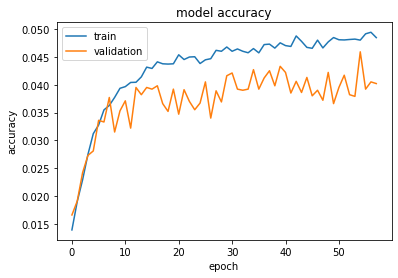

In [0]:

#  "Accuracy"
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


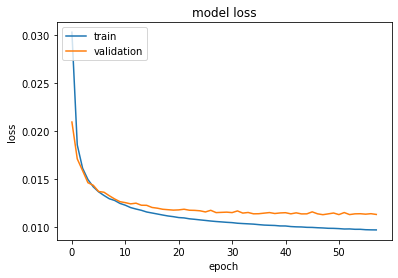

In [0]:

# "Loss"
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


**Part-3: K-Means Clustering with Auto-Encoder**

In [0]:
def assign_cluster(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(10):

        # find index of points in cluster
        label = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        label.append(actual_labels[index])

        # determine most common label
        if len(label[0]) == 1:
            counts = np.bincount(label[0])
        else:
            counts = np.bincount(np.squeeze(label))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        
    return inferred_labels  

def assign_data(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predict_label = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, clusters in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if clusters in value:
                predict_label[i] = key
                
    return predict_label

In [0]:
encoder = keras.backend.function([autoencoder.layers[0].input],[autoencoder.layers[4].output]) 
encoded_image = encoder([x_train])[0].reshape(-1,10)

km = KMeans(
      n_clusters=10, init='k-means++',
      n_init=10, max_iter=300,
      tol=1e-40, random_state=10
  )

y_KMeans  = km.fit_predict(encoded_image)

cluster_labels = assign_cluster(km, train_y)
predicted_Y = assign_data(km.labels_, cluster_labels)

kmeans_acc = metrics.accuracy_score(train_y, y_predicted)


0.5713


In [0]:
print("Accuracy",kmeans_acc*100,'%')

Accuracy 57.13 %


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

KM_ConfusionMatrix=metrics.confusion_matrix(train_y, y_KMeans)

print(KM_ConfusionMatrix)

[[ 168  262   45  343    8 4687    8   27    1  451]
 [  44   83    3 5697   13   16    2   30    0  112]
 [1002 2479   52   12    9   31    1 2303    1  110]
 [ 137   89   11 3767    3  225    0   29    0 1739]
 [ 453  658   23   26    3    9    0 3519    0 1309]
 [ 442    0   55    1 3381    0 1443    1  676    1]
 [1268 1262  139  116    5 1310    3 1411    0  486]
 [   2    0   17    0 5236    0   12    0  733    0]
 [1909  280 3392   32  116   18   22   36   26  169]
 [   7    0   45    1  318    6 1803    0 3817    3]]


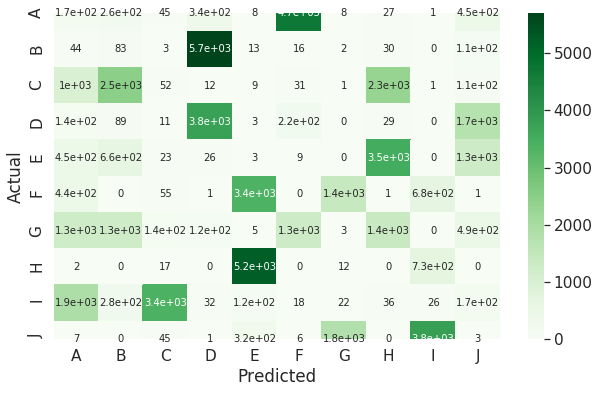

In [0]:
df_cm = pd.DataFrame(KM_ConfusionMatrix, index = [i for i in "ABCDEFGHIJ"],
                  columns = [i for i in "ABCDEFGHIJ"])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,6))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 10})

**Part-4: Gaussian Mixture Model Clustering with Auto-Encoder**

In [0]:
def GM_assign_cluster(gmm, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """
    inferred_labels = {}

    for i in range(10):

        # find index of points in cluster
        labels = []
        index = np.where(gmm == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def GM_assign_data_label(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [0]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=10,tol=1e-5,max_iter=300,random_state=31,verbose=1)
output = gm.fit_predict(encoded_image)

gm_cluster_labels = GM_assign_cluster(output, train_y)
gm_y_predicted = GM_assign_data_label(output, gm_cluster_labels)

gm_acc = metrics.accuracy_score(train_y, gm_y_predicted)
print(gm_acc)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
0.60795


In [1]:
print("Accuracy",gm_acc*100,'%')

Accuracy 60.795 %


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

gmm_cm=metrics.confusion_matrix(train_y, gm_y_predicted)

print(gmm_cm)

[[4364  132   27  816   10    2    0    1  648    0]
 [  27 5513   29  305   17    6    0    0  103    0]
 [  26    2 2755  480 2441    1    0    0  295    0]
 [1264 2396    4 1875    2    0    0    0  459    0]
 [  79    6 1389 1628 2599    0    0    0  299    0]
 [   0    0    2    0    0 3608    0  149 2075  166]
 [1170   25 1649 1298 1311    1    0    0  546    0]
 [   0    0    0    0    0  735    0 4910   39  316]
 [   0    3    6  215    6   52    0    3 5713    2]
 [   0    0    0    6    1  145    0  488  220 5140]]


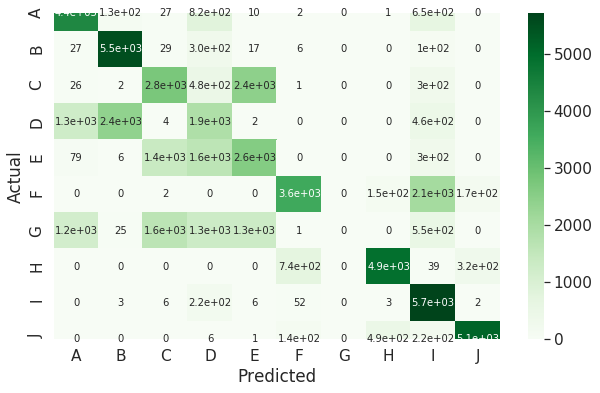

In [0]:
df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJ"],
                  columns = [i for i in "ABCDEFGHIJ"])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,6))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 10})# font size